## Review
### This recitation (12.06) covers two following lectures below:
- **11.29 (Wed)**
- **12.04 (Mon)**


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# import torchvision and matplotlib to download and visualize cifar10
import torchvision
from matplotlib.pyplot import imshow
import cv2

np.random.seed(20231206)

### What We Have Studied So Far

<img src="https://drive.google.com/uc?export=view&id=1bOlHLJ2c7xd1tcJW6Wy_penv55NKfOs3" alt="Drawing" height=300 />

So far, we have studied various field in AI.


*    **Computer Vision:** CNN, **Vision Transformer**
*   **Language:** RNN, LSTM, Transformer





1. **Convolutional Neural Network (CNN):**
CNNs are widely used for image classification and computer vision tasks. They consist of convolutional layers that learn spatial hierarchies of features in an image.

2. **Recurrent Neural Network (RNN):**
RNNs are designed to handle sequential data by maintaining a hidden state that is updated at each time step. This allows them to capture temporal dependencies in the input sequence. However, traditional RNNs struggle with long-term dependencies (That's why we have studied LSTM!).

3. **Long Short-Term Memory (LSTM):**
LSTMs are a type of RNN that addresses the vanishing gradient problem, allowing them to capture long-term dependencies in sequential data. LSTMs have memory cells and gates that control the flow of information, making them more effective at learning and remembering over longer sequences.

4. **Transformer:**
The Transformer architecture, introduced by Vaswani et al. in the paper "Attention is All You Need," is a neural network architecture based on the self-attention mechanism. Unlike traditional sequence-to-sequence models with recurrent or convolutional layers, Transformers rely on attention mechanisms to capture relationships between different parts of the input sequence in parallel.

5. **Vision Transformer (ViT):**
Vision Transformers represent an architecture that applies transformer-based models, originally designed for sequential data like text, to vision tasks. ViT divides an image into fixed-size patches, linearly embeds these patches, and processes them through transformer layers to capture long-range dependencies. The positional information of patches is crucial for capturing spatial relationships.

In this class, we are going to visualize the features from ViT!

### Vision Transformer


<img src="https://drive.google.com/uc?export=view&id=1zvslCeO1Uvcj6YUXJ58VMU0923UQ9B9Q" alt="Drawing" height=500 />

**Vision transformers** have extensive applications in popular image recognition tasks such as object detection, segmentation, image classification, and action recognition. Moreover, ViTs are applied in generative modeling and multi-model tasks, including visual grounding, visual-question answering, and visual reasoning.

## Build Modules for ViT

We are going to utilize Pytorch and some neccesary libraries.

In [ ]:
%%capture
!pip install timm

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from timm import create_model

### Hugging Face - Vision Transformer

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"You will run the model using [{device}]")

You will run the model using [cpu]


In [ ]:
# Hugging Face transformer libary
# You can get more information in https://huggingface.co/docs/transformers/main/model_doc/vit
from transformers import ViTConfig, ViTModel

configuration = ViTConfig()
model = ViTModel(configuration)
configuration = model.config
model.config.return_dict = False
print(model)

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [ ]:
# Define input resolutinon and some preprocessing.
IMG_SIZE = (224, 224)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
              T.Resize(IMG_SIZE),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

In [ ]:
%%capture
# Download image to visualize
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

!wget https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/santorini.png?raw=true -O santorini.png
img = PIL.Image.open('santorini.png')
img_tensor = transforms(img).unsqueeze(0).to(device)

### Run the Vision Transformer

Transformer output shape has torch.Size([1, 197, 768])


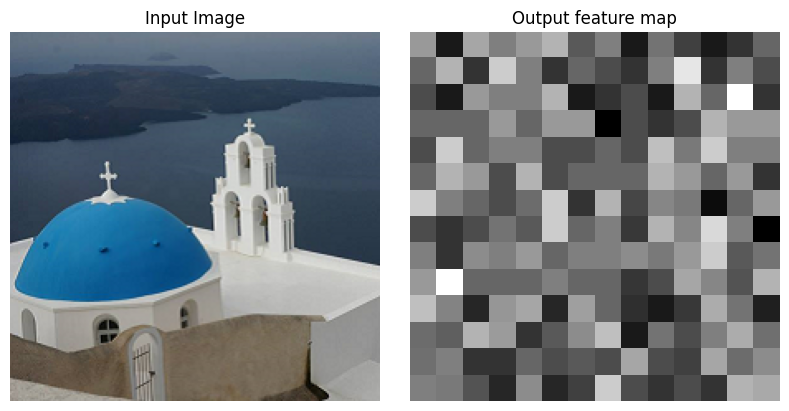

In [ ]:
# Inference
output = model(img_tensor)
print(f'Transformer output shape has {output[0].shape}')

fm = output[0][0][:196, :].view(14,14,768).cpu().detach().numpy()

fm = np.sum(fm, axis=2)
fm = fm / 768.

fig = plt.figure(figsize=(8,4), constrained_layout = True)

plt.subplot(121)
plt.imshow(img)
plt.title('Input Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(fm, cmap = 'gray')
plt.title('Output feature map')
plt.axis('off')
plt.show()

### What Happened in ...?

```
output = model(img_tensor) # torch.Size([1, 197, 768])
```

<img src='https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/vit_input.png?raw=true'>


**1. Split Image into Patches**  
The input image is split into 14 x 14 vectors with dimension of 768 by Conv2d (k=16x16) with stride=(16, 16).

**2. Add Position Embeddings**  
Learnable position embedding vectors are added to the patch embedding vectors and fed to the transformer encoder.

**3. Transformer Encoder**

The embedding vectors are encoded by the transformer encoder. The dimension of input and output vectors are the same. The Trasnformer Encoder dontains self-attention modules!

**4. MLP (Classification) Head**

The output from the encoder is fed to the MLP head for classification to output the final classification results.


#### Patch Embedding

The input image is split into N patches (N = 14 x 14 for ViT-Base)
and converted to D=768 embedding vectors by learnable 2D convolution:
```
Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
```

In [ ]:
patches = model.embeddings(img_tensor)  # patch embedding convolution
print("Image tensor: ", img_tensor.shape)
print("Patch embeddings: ", patches.shape)
print(model.embeddings)

Image tensor:  torch.Size([1, 3, 224, 224])
Patch embeddings:  torch.Size([1, 197, 768])
ViTEmbeddings(
  (patch_embeddings): ViTPatchEmbeddings(
    (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(p=0.0, inplace=False)
)


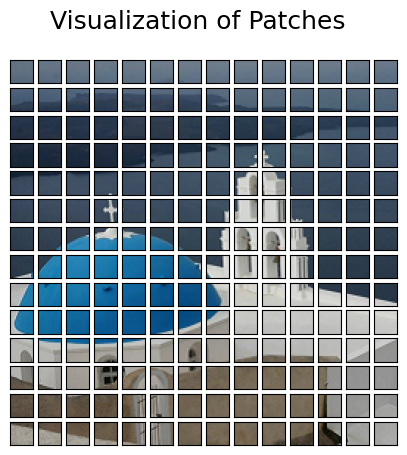

In [ ]:
# Visuallize the patches
fig = plt.figure(figsize=(5, 5))
fig.suptitle("Visualization of Patches", fontsize=18)
img = np.asarray(img)
for i in range(0, 196):
    x = i % 14
    y = i // 14
    patch = img[y*16:(y+1)*16, x*16:(x+1)*16]
    ax = fig.add_subplot(14, 14, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

#### Positional Encoding
(Review) See **21:00** of Lecture below:

https://www.youtube.com/watch?v=VqsmlleK6OI&t=1283s

In [ ]:
def get_pos_encoding(max_len, d_model):
    # YOUR CODE HERE
    pos_enc = np.array([[pos / np.power(10000, 2 * (i // 2) / d_model) for i in range(d_model)] for pos in range(max_len)])
    pos_enc[:, 0::2] = np.sin(pos_enc[:, 0::2])
    pos_enc[:, 1::2] = np.cos(pos_enc[:, 1::2])
    pos_enc = pos_enc[np.newaxis, ...]
    return torch.tensor(pos_enc)

# Example usage
max_sequence_length = 197 # (196+1)
hidden_size = 768

pos_embed = get_pos_encoding(max_sequence_length, hidden_size)

print(pos_embed.shape)  # Output: (1, 197, 768)

torch.Size([1, 197, 768])


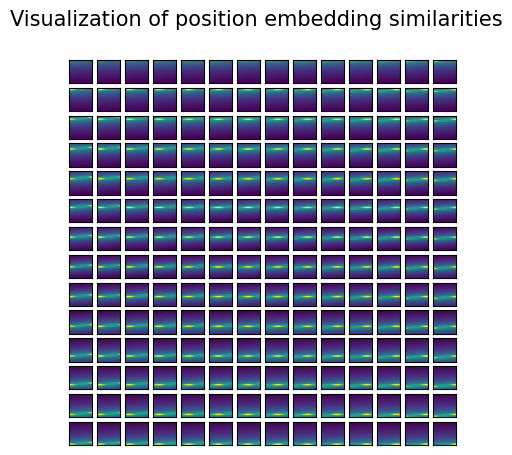

In [ ]:
# Visualize positional Encoding
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fig = plt.figure(figsize=(5, 5))
fig.suptitle("Visualization of position embedding similarities", fontsize=15)
for i in range(1, pos_embed.shape[1]):
    sim = F.cosine_similarity(pos_embed[0, i:i+1], pos_embed[0, 1:], dim=1)
    sim = sim.reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(14, 14, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

#### Transformer Input

In [ ]:
patches = model.embeddings(img_tensor)
print("Transformer input: ", patches.shape)
print("Class token: ", patches[:, 0, :].shape)

Transformer input:  torch.Size([1, 197, 768])
Class token:  torch.Size([1, 768])


#### Encoder Blocks in Transformer Encoder

In [ ]:
model.encoder.layer

ModuleList(
  (0-11): 12 x ViTLayer(
    (attention): ViTAttention(
      (attention): ViTSelfAttention(
        (query): Linear(in_features=768, out_features=768, bias=True)
        (key): Linear(in_features=768, out_features=768, bias=True)
        (value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (output): ViTSelfOutput(
        (dense): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (intermediate): ViTIntermediate(
      (dense): Linear(in_features=768, out_features=3072, bias=True)
      (intermediate_act_fn): GELUActivation()
    )
    (output): ViTOutput(
      (dense): Linear(in_features=3072, out_features=768, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  )
)

In [ ]:
print(f"Input shape: {patches.shape}")
x = patches.clone()
for i, blk in enumerate(model.encoder.layer):
    print(f"Pass through block-{i+1}")
    x = blk(x)
    if isinstance(x, tuple):
      x = x[0]

transformer_output = x
print(f"Outputs shape: {transformer_output.shape}")

Input shape: torch.Size([1, 197, 768])
Pass through block-1
Pass through block-2
Pass through block-3
Pass through block-4
Pass through block-5
Pass through block-6
Pass through block-7
Pass through block-8
Pass through block-9
Pass through block-10
Pass through block-11
Pass through block-12
Outputs shape: torch.Size([1, 197, 768])


#### Self-Attention

In [ ]:
print("Transformer Multi-head Attention block:")
attention = model.encoder.layer[0].attention.attention
print(attention)
# We calucalte qkv at once!

Transformer Multi-head Attention block:
ViTSelfAttention(
  (query): Linear(in_features=768, out_features=768, bias=True)
  (key): Linear(in_features=768, out_features=768, bias=True)
  (value): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)


In [ ]:
query = attention.query(patches)
key = attention.key(patches)
value = attention.value(patches)

# Aware of the shape. Each has hidden dimension of 768.
print(f'Query : {query[0].shape}')
print(f'Key   : {key[0].shape}')
print(f'Value : {value[0].shape}')

Query : torch.Size([197, 768])
Key   : torch.Size([197, 768])
Value : torch.Size([197, 768])


In [ ]:
# Split qkv into mulitple q, k, and v vectors for 'multi-head' attantion
# In this case, we set head = 12

qkv = torch.cat([query, key, value])
print(f'qkv : {qkv.shape}')
qkv = qkv.permute(1,0,2).reshape(197, 3, 12, 64)
print(qkv.shape)

q = qkv[:, 0].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
k = qkv[:, 1].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
kT = k.permute(0, 2, 1)  # (H=12, D/H=64, N=197)

# We transpose it to attend it wtih query
print("key shape: ", kT.shape)

qkv : torch.Size([3, 197, 768])
torch.Size([197, 3, 12, 64])
key shape:  torch.Size([12, 64, 197])


Attention Matrix:  torch.Size([12, 197, 197])


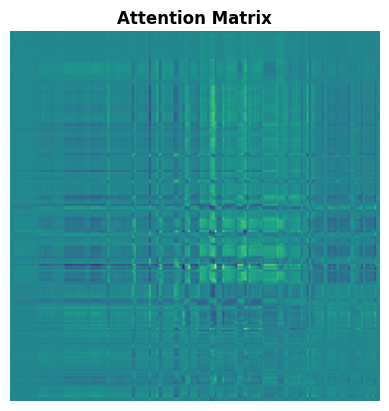

In [ ]:
# Get Attention Matrix
attention_matrix = q @ kT

print("Attention Matrix: ", attention_matrix.shape)

plt.imshow(attention_matrix[10].detach().cpu().numpy())
plt.title('Attention Matrix', fontweight='bold')
plt.axis('off')
plt.show()

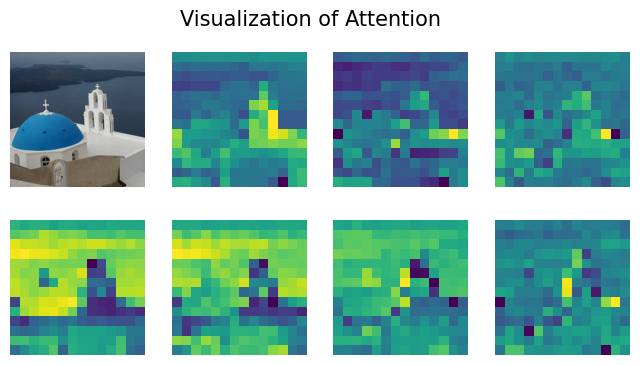

In [ ]:
# Visualize attention matrix
fig = plt.figure(figsize=(8, 4))
fig.suptitle("Visualization of Attention", fontsize=15)
img = np.asarray(img)
ax = fig.add_subplot(2, 4, 1)
ax.imshow(img)
ax.axis('off')
for i in range(7):  # visualize the 100th rows of attention matrices in the 0-7th heads
    attn_heatmap = attention_matrix[i, 100, 1:].reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(2, 4, i+2)
    ax.axis('off')
    ax.imshow(attn_heatmap)